# Gender Classification using Neural Networks

## Importing dependencies

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import os
import random
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, classification_report
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score

## EDA

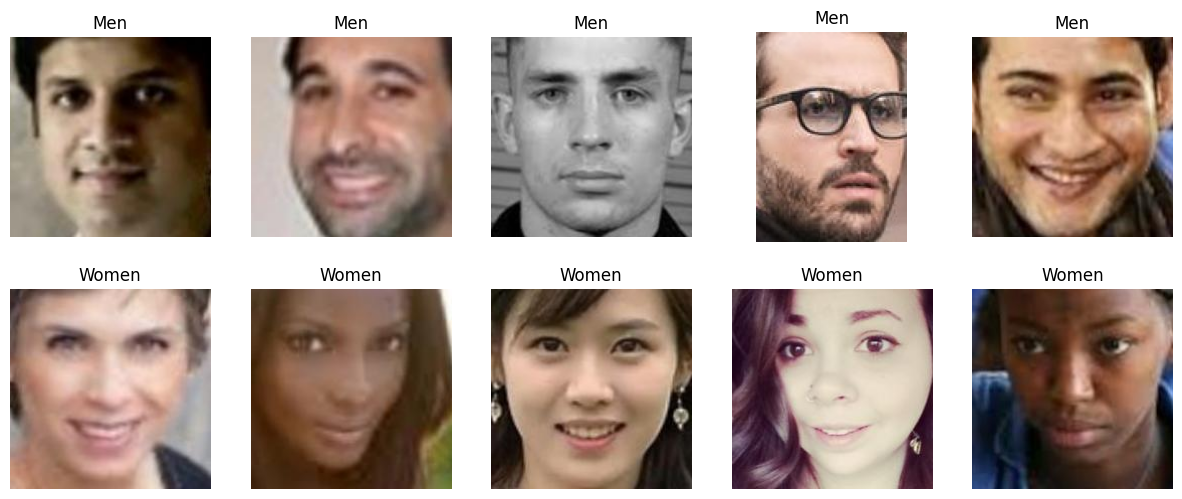

In [16]:
men_folder = './Model Enhancement/Dataset preparation/Gender Dataset (16-60)/man'
women_folder = './Model Enhancement/Dataset preparation/Gender Dataset (16-60)/woman'

# Get a random sample of file names from each folder
men_image_files = random.sample(os.listdir(men_folder), 5)
women_image_files = random.sample(os.listdir(women_folder), 5)

# Read and plot the random sample of images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, image_file in enumerate(men_image_files):
    img_path = os.path.join(men_folder, image_file)
    men_images = cv2.imread(img_path)
    axes[0, i].imshow(cv2.cvtColor(men_images, cv2.COLOR_BGR2RGB))
    axes[0, i].axis('off')
    axes[0, i].set_title('Men')

for i, image_file in enumerate(women_image_files):
    img_path = os.path.join(women_folder, image_file)
    women_images = cv2.imread(img_path)
    axes[1, i].imshow(cv2.cvtColor(women_images, cv2.COLOR_BGR2RGB))
    axes[1, i].axis('off')
    axes[1, i].set_title('Women')

plt.show()

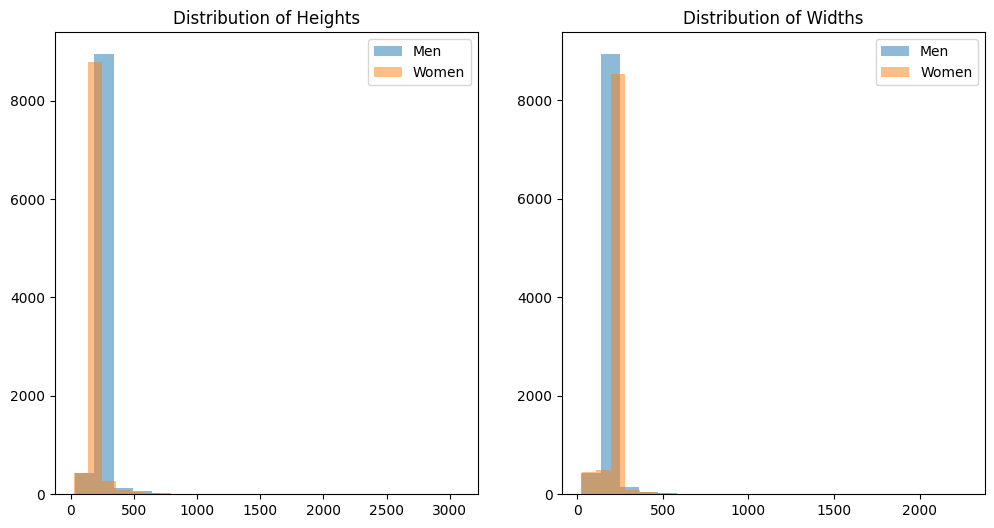

In [17]:
men_images = [cv2.imread(os.path.join(men_folder, img)) for img in os.listdir(men_folder)[:]]
women_images = [cv2.imread(os.path.join(women_folder, img)) for img in os.listdir(women_folder)[:]]


men_image_sizes = [img.shape for img in men_images]
women_image_sizes = [img.shape for img in women_images]

men_heights = [img.shape[0] for img in men_images]
men_widths = [img.shape[1] for img in men_images]

women_heights = [img.shape[0] for img in women_images]
women_widths = [img.shape[1] for img in women_images]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(men_heights, bins=20, alpha=0.5, label='Men')
plt.hist(women_heights, bins=20, alpha=0.5, label='Women')
plt.title('Distribution of Heights')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(men_widths, bins=20, alpha=0.5, label='Men')
plt.hist(women_widths, bins=20, alpha=0.5, label='Women')
plt.title('Distribution of Widths')
plt.legend()

plt.show()


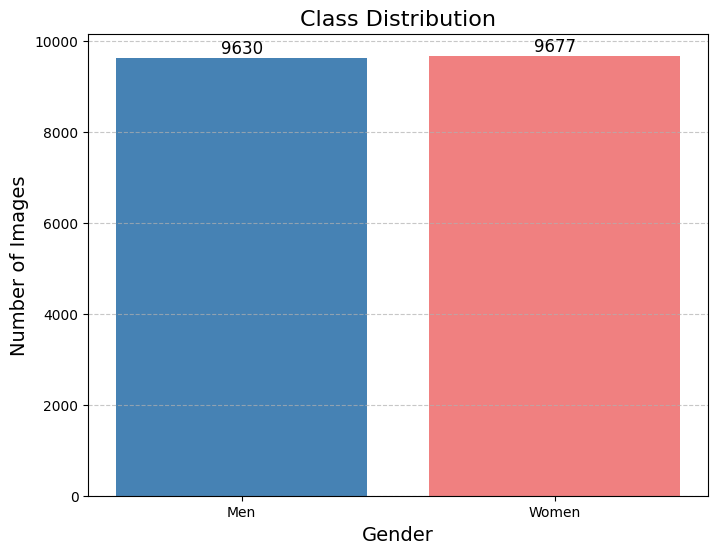

In [18]:
# Assuming men_folder and women_folder are defined
men_count = len(os.listdir(men_folder))
women_count = len(os.listdir(women_folder))

# Bar chart with styling
plt.figure(figsize=(8, 6))
bars = plt.bar(['Men', 'Women'], [men_count, women_count], color=['steelblue', 'lightcoral'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha='center', va='bottom', color='black', fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Title and labels
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)

# Show the plot
plt.show()


## Data Directory

In [2]:
data_dir = r'./Model Enhancement/Dataset preparation/Gender Dataset (16-60)'

## Initial Parameters

In [2]:
img_width, img_height = 96, 96
batch_size = 64
test_split_ratio = 0.2
epochs = 35

## Preprocessing

In [3]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=test_split_ratio)


## Training Data Generator Configuration

In [5]:
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Use 'binary' for binary classification
    subset='training',  # Specify 'training' for the training set
    shuffle=True
)

Found 15446 images belonging to 2 classes.


## Test Data Generator Configuration

In [6]:
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Use 'binary' for binary classification
    subset='validation',  # Specify 'validation' for the testing set
    shuffle=False  # Set to False for evaluation
)


Found 3861 images belonging to 2 classes.


# CNN Model

## Defining a custom learning rate scheduler

In [4]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 32:
        lr *= 0.5
    elif epoch > 28:
        lr *= 0.7
    elif epoch > 20:
        lr *= 0.9
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


In [5]:
# Model creation
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully connected layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))


## Model Optimization and Compilation

In [6]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


## Model Summary

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 96, 96, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1

## Model Training

In [10]:
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=[lr_scheduler])

Epoch 1/35
242/242 [==============================] - 587s 2s/step - loss: 0.4022 - accuracy: 0.8493 - val_loss: 0.6523 - val_accuracy: 0.5840 - lr: 0.0010
Epoch 2/35
242/242 [==============================] - 435s 2s/step - loss: 0.2214 - accuracy: 0.9160 - val_loss: 0.4250 - val_accuracy: 0.8024 - lr: 0.0010
Epoch 3/35
242/242 [==============================] - 425s 2s/step - loss: 0.1737 - accuracy: 0.9351 - val_loss: 0.2418 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 4/35
242/242 [==============================] - 424s 2s/step - loss: 0.1475 - accuracy: 0.9457 - val_loss: 0.3126 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 5/35
242/242 [==============================] - 430s 2s/step - loss: 0.1594 - accuracy: 0.9435 - val_loss: 0.4864 - val_accuracy: 0.8283 - lr: 0.0010
Epoch 6/35
242/242 [==============================] - 447s 2s/step - loss: 0.1228 - accuracy: 0.9564 - val_loss: 0.3356 - val_accuracy: 0.8959 - lr: 0.0010
Epoch 7/35
242/242 [==============================] - 437s 2s/st

## Plotting the training and validation accuracy and loss of the CNN model

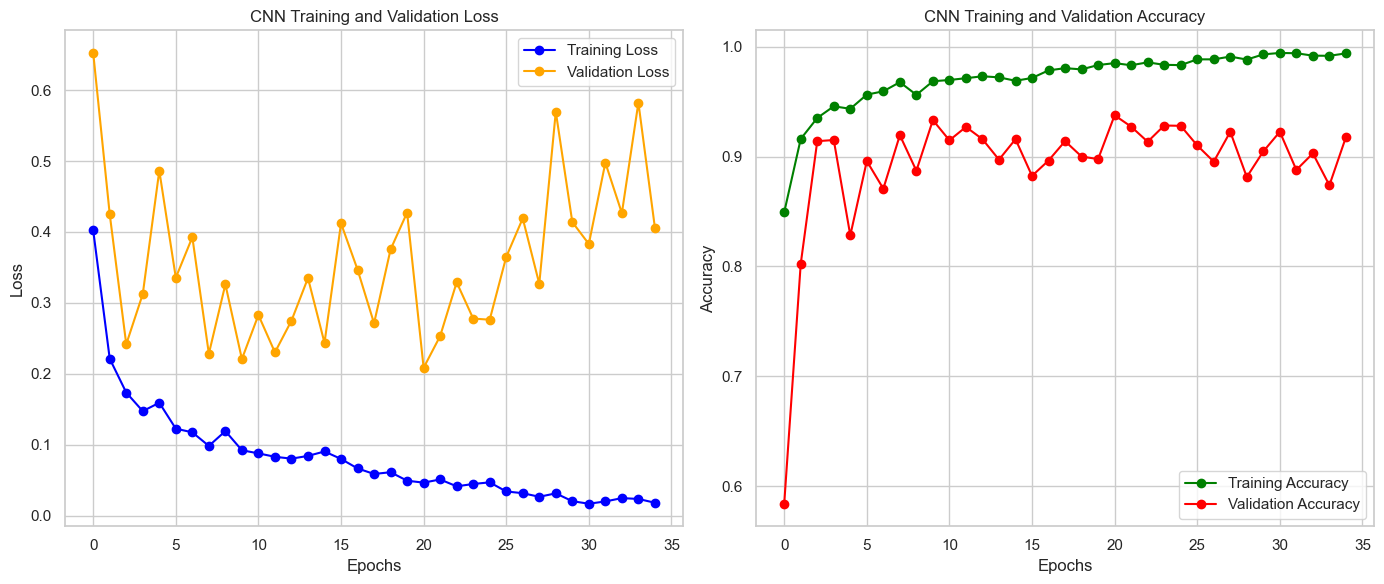

In [30]:
# Set a seaborn style
sns.set(style="whitegrid")

# Access the training history
cnn_history_dict = history.history

# Plotting the training and validation loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history_dict['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(cnn_history_dict['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history_dict['accuracy'], label='Training Accuracy', color='green', marker='o')
plt.plot(cnn_history_dict['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


## Saving the model

In [12]:
model.save('gender_classification_model_v22.model')

INFO:tensorflow:Assets written to: gender_classification_model_v22.model\assets


INFO:tensorflow:Assets written to: gender_classification_model_v22.model\assets


# VGG16 Model

## Initialization of VGG16 Base Model with Pre-trained Weights

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

## Freezing Layers in the Base Model

In [9]:
for layer in base_model.layers:
    layer.trainable = False

## Custom Classifier Layer on Top of Base Model

In [10]:
model = Flatten()(base_model.output)
model = Dense(512, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(1, activation='sigmoid')(model)

## Creating the final model

In [11]:
vgg16_model = Model(inputs=base_model.input, outputs=model)

## Model Optimization and compilation

In [12]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, decay=1e-4 / epochs)
vgg16_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

## Model Summary

In [13]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

## Model Training

In [18]:
vgg16_history = vgg16_model.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=[lr_scheduler])

Epoch 1/35
242/242 [==============================] - 1368s 6s/step - loss: 0.3382 - accuracy: 0.8548 - val_loss: 0.3919 - val_accuracy: 0.8373 - lr: 0.0010
Epoch 2/35
242/242 [==============================] - 1437s 6s/step - loss: 0.2421 - accuracy: 0.9013 - val_loss: 0.3662 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 3/35
242/242 [==============================] - 1425s 6s/step - loss: 0.2250 - accuracy: 0.9100 - val_loss: 0.5113 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 4/35
242/242 [==============================] - 1437s 6s/step - loss: 0.2099 - accuracy: 0.9171 - val_loss: 0.3110 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 5/35
242/242 [==============================] - 1437s 6s/step - loss: 0.1972 - accuracy: 0.9218 - val_loss: 0.4107 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 6/35
242/242 [==============================] - 1431s 6s/step - loss: 0.1897 - accuracy: 0.9257 - val_loss: 0.3700 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 7/35
242/242 [==============================] - 1449

KeyboardInterrupt: 

I did not train the model fully due to its extensive time consumption.

## Plotting the training and validation accuracy and loss of the VGG16 model

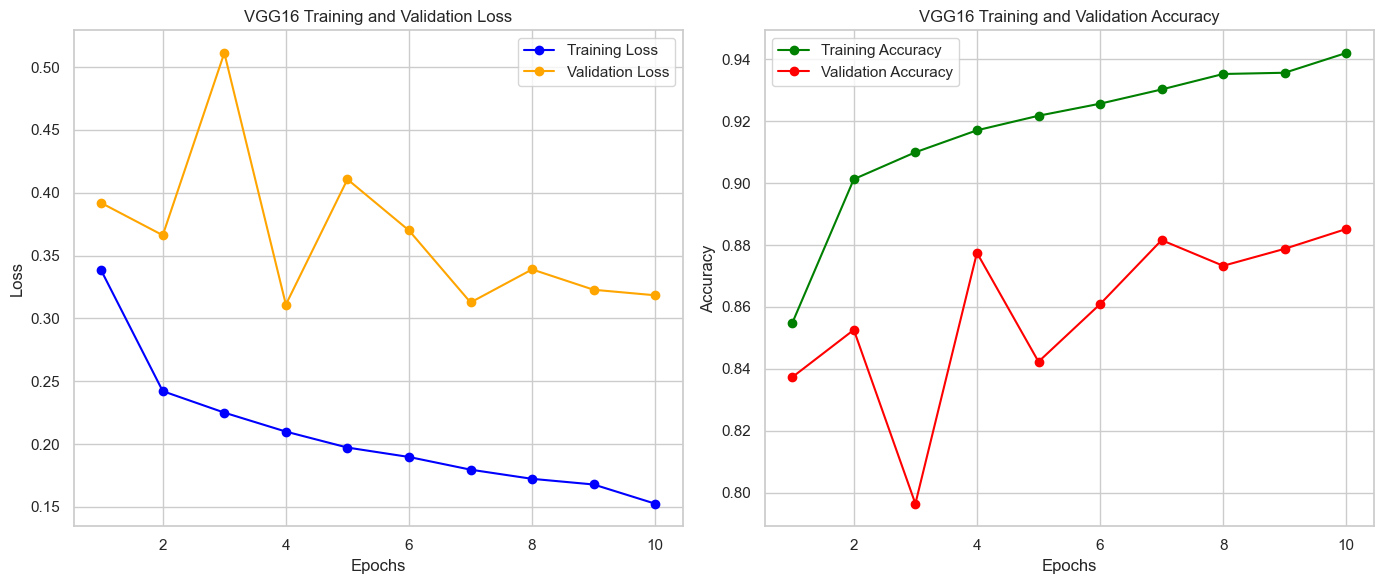

In [26]:
# Number of epochs
epochs = list(range(1, 11))

# ELost the data so created list
training_loss = [0.3382, 0.2421, 0.2250, 0.2099, 0.1972, 0.1897, 0.1796, 0.1723, 0.1678, 0.1525]
training_accuracy = [0.8548, 0.9013, 0.9100, 0.9171, 0.9218, 0.9257, 0.9303, 0.9353, 0.9357, 0.9421]

validation_loss = [0.3919, 0.3662, 0.5113, 0.3110, 0.4107, 0.3700, 0.3127, 0.3390, 0.3228, 0.3184]
validation_accuracy = [0.8373, 0.8526, 0.7964, 0.8775, 0.8423, 0.8609, 0.8816, 0.8733, 0.8788, 0.8852]

# Plot the training and validation loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', color='orange', marker='o')
plt.title('VGG16 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', color='red', marker='o')
plt.title('VGG16 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


## Saving the model

In [19]:
vgg16_model.save('gender_classification_vgg16_model.model')

INFO:tensorflow:Assets written to: gender_classification_vgg16_model.model\assets


INFO:tensorflow:Assets written to: gender_classification_vgg16_model.model\assets


## ResNet Model

## Load Pre-trained ResNet50 Model with ImageNet Weights

In [14]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

## Freeze Layers in the ResNet50 Model to Retain Pre-trained Weights

In [15]:
for layer in base_model.layers:
    layer.trainable = False

## Customize Fully Connected Layers for Gender Classification on Top of ResNet50 Base Model

In [16]:
model = Flatten()(base_model.output)
model = Dense(512, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(1, activation='sigmoid')(model)

## Create ResNet50-based Model for Gender Classification

In [17]:
resnet_model = Model(inputs=base_model.input, outputs=model)

## Model Optimization and Compilation

In [19]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, decay=1e-4 / epochs)
resnet_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


## Model Summary

In [20]:
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 102, 102, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 48, 48, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

## Model Training

In [27]:
resnet_history = resnet_model.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=[lr_scheduler])

Epoch 1/35
242/242 [==============================] - 574s 2s/step - loss: 0.6462 - accuracy: 0.6325 - val_loss: 0.5850 - val_accuracy: 0.6887 - lr: 0.0010
Epoch 2/35
242/242 [==============================] - 600s 2s/step - loss: 0.5735 - accuracy: 0.7038 - val_loss: 0.5879 - val_accuracy: 0.6706 - lr: 0.0010
Epoch 3/35
242/242 [==============================] - 563s 2s/step - loss: 0.5484 - accuracy: 0.7272 - val_loss: 0.5280 - val_accuracy: 0.7376 - lr: 0.0010
Epoch 4/35
242/242 [==============================] - 571s 2s/step - loss: 0.5339 - accuracy: 0.7374 - val_loss: 0.5245 - val_accuracy: 0.7353 - lr: 0.0010
Epoch 5/35
242/242 [==============================] - 578s 2s/step - loss: 0.5236 - accuracy: 0.7459 - val_loss: 0.5607 - val_accuracy: 0.7146 - lr: 0.0010
Epoch 6/35
242/242 [==============================] - 597s 2s/step - loss: 0.5134 - accuracy: 0.7529 - val_loss: 0.5251 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 7/35
242/242 [==============================] - 573s 2s/st

## Saving the trained model

In [28]:
resnet_model.save('gender_classification_resnet_model.model')

INFO:tensorflow:Assets written to: gender_classification_resnet_model.model\assets


INFO:tensorflow:Assets written to: gender_classification_resnet_model.model\assets


## Plotting the training and validation accuracy and loss of the ResNet model

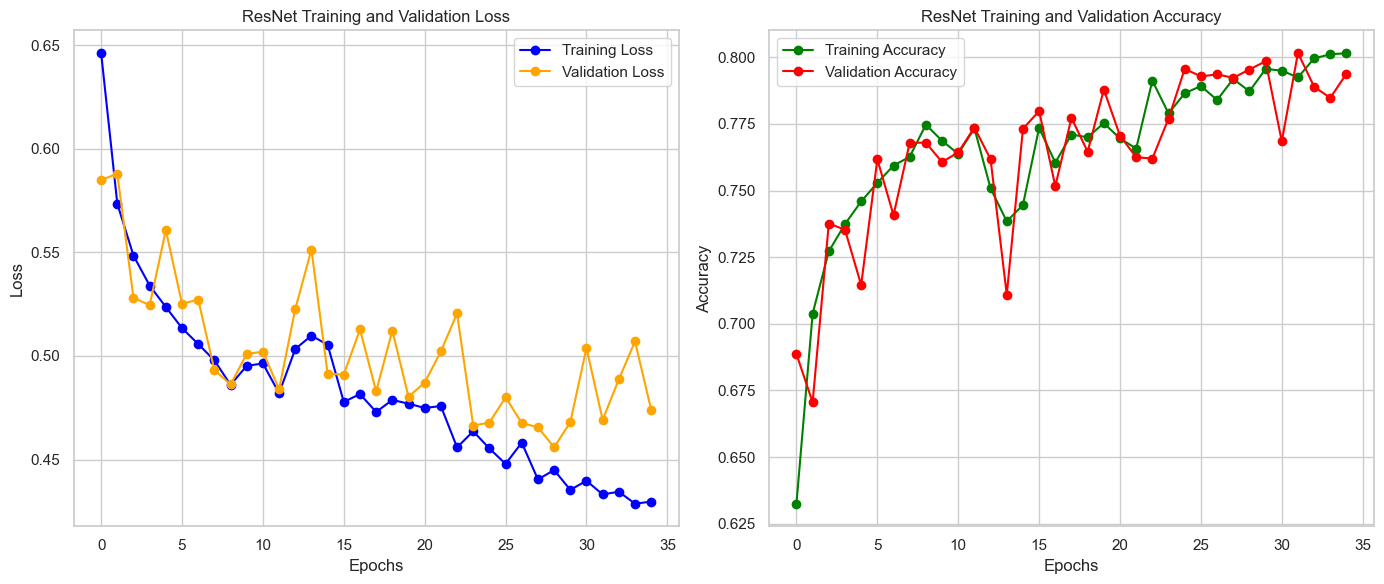

In [31]:
# Set a seaborn style
sns.set(style="whitegrid")

# Access the training history
resnet_history_dict = resnet_history.history

# Plotting the training and validation loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(resnet_history_dict['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(resnet_history_dict['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title('ResNet Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(resnet_history_dict['accuracy'], label='Training Accuracy', color='green', marker='o')
plt.plot(resnet_history_dict['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
plt.title('ResNet Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


## CNN Model Assessing

## Confusion Matrix

Found 496 images belonging to 2 classes.


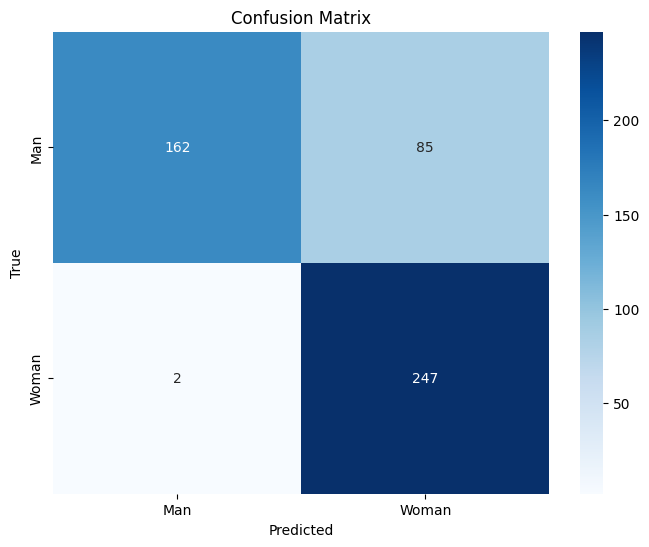

In [32]:
# Directory containing the test images
test_data_dir = "D:\Jupyter\Data Science Project\genderClassification\I don't know\Test"  # Replace with the path to your test data directory
img_width, img_height = 96, 96  # Adjust based on your image dimensions
batch_size = 64

# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Adjust based on your problem (binary or categorical)
    shuffle=False  # Set to False for evaluation
)

# Load your pre-trained VGG16 model
cnn_model = load_model('gender_classification_model_v22.model')  # Replace with the path to your VGG16 model

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Iterate over subdirectories (Man and Woman)
for class_label in ['Man', 'Woman']:
    class_path = os.path.join(test_data_dir, class_label)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # List all image files in the subdirectory
        image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Select 302 images from each subdirectory
        image_files = image_files[:302]

        # Iterate over test images
        for img_path in image_files:
            # Load and preprocess the image
            img = load_img(img_path, target_size=(img_width, img_height))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict the gender using the VGG16 model
            prediction = cnn_model.predict(img_array, verbose=0)[0]
            predicted_label = 1 if prediction[0] > 0.5 else 0

            # Extract the true label from the subdirectory name
            true_label = 1 if class_label == 'Woman' else 0

            # Append true and predicted labels to the lists
            y_true.append(true_label)
            y_pred.append(predicted_label)

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Man", "Woman"],
            yticklabels=["Man", "Woman"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [33]:
cm

array([[162,  85],
       [  2, 247]], dtype=int64)

In [34]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Man", "Woman"]))

Classification Report:
              precision    recall  f1-score   support

         Man       0.99      0.66      0.79       247
       Woman       0.74      0.99      0.85       249

    accuracy                           0.82       496
   macro avg       0.87      0.82      0.82       496
weighted avg       0.87      0.82      0.82       496



## ROC Curve

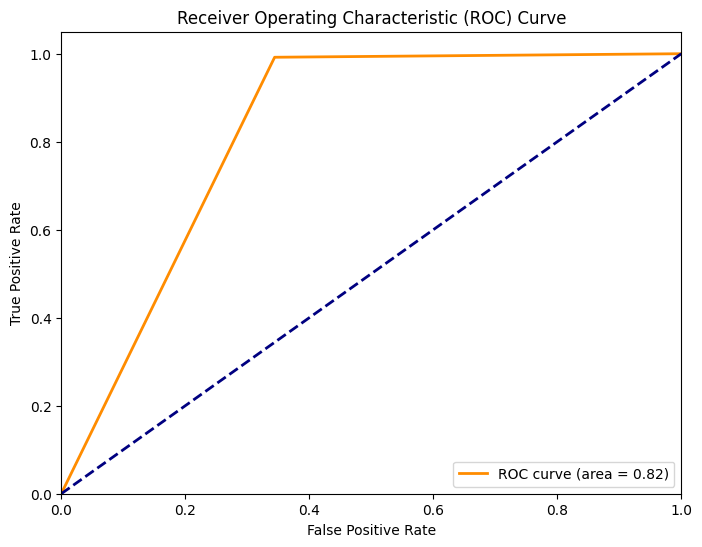

In [35]:
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Precision Recall Curve

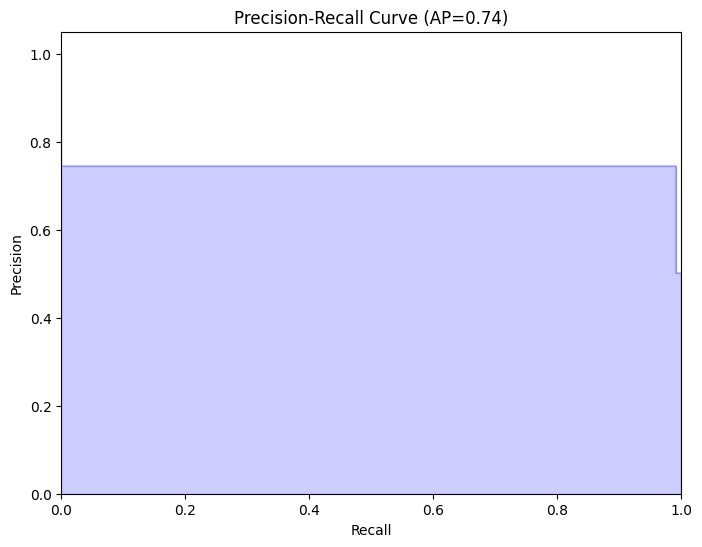

In [36]:
# Compute Precision-Recall curve and area for each class
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:.2f})'.format(average_precision))
plt.show()


## VGG16 Model Assessing

## Confusion Matrix

Found 496 images belonging to 2 classes.


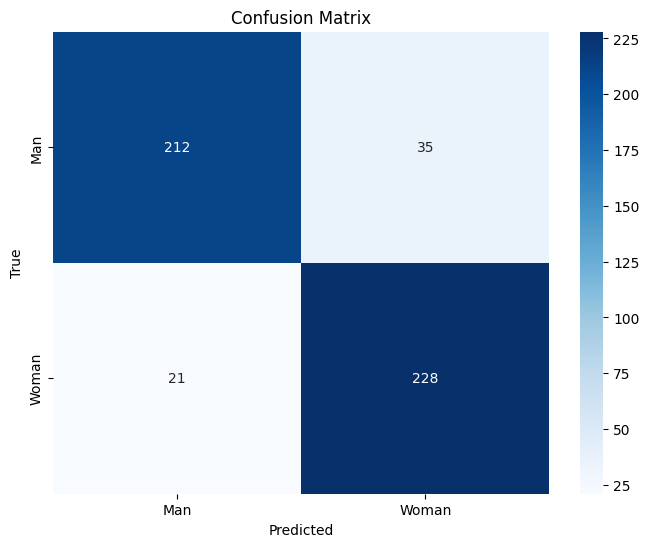

In [37]:
# Directory containing the test images
test_data_dir = "D:\Jupyter\Data Science Project\genderClassification\I don't know\Test"  # Replace with the path to your test data directory
img_width, img_height = 96, 96  # Adjust based on your image dimensions
batch_size = 64

# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Adjust based on your problem (binary or categorical)
    shuffle=False  # Set to False for evaluation
)

# Load your pre-trained VGG16 model
vgg16_model = load_model('gender_classification_vgg16_model.model')  # Replace with the path to your VGG16 model

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Iterate over subdirectories (Man and Woman)
for class_label in ['Man', 'Woman']:
    class_path = os.path.join(test_data_dir, class_label)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # List all image files in the subdirectory
        image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Select 302 images from each subdirectory
        image_files = image_files[:302]

        # Iterate over test images
        for img_path in image_files:
            # Load and preprocess the image
            img = load_img(img_path, target_size=(img_width, img_height))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict the gender using the VGG16 model
            prediction = vgg16_model.predict(img_array,verbose=0)[0]
            predicted_label = 1 if prediction[0] > 0.5 else 0

            # Extract the true label from the subdirectory name
            true_label = 1 if class_label == 'Woman' else 0

            # Append true and predicted labels to the lists
            y_true.append(true_label)
            y_pred.append(predicted_label)

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Man", "Woman"],
            yticklabels=["Man", "Woman"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [38]:
cm

array([[212,  35],
       [ 21, 228]], dtype=int64)

In [39]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Man", "Woman"]))

Classification Report:
              precision    recall  f1-score   support

         Man       0.91      0.86      0.88       247
       Woman       0.87      0.92      0.89       249

    accuracy                           0.89       496
   macro avg       0.89      0.89      0.89       496
weighted avg       0.89      0.89      0.89       496



## ROC Curve

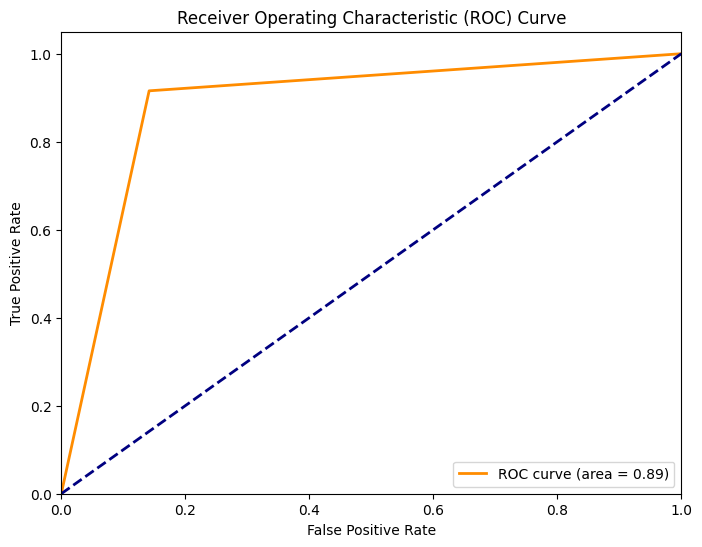

In [40]:
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Precision Recall Curve

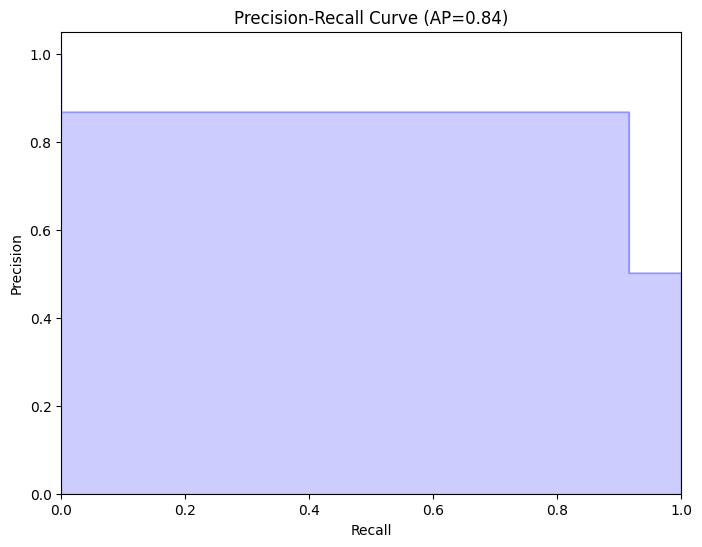

In [41]:
# Compute Precision-Recall curve and area for each class
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:.2f})'.format(average_precision))
plt.show()


## ResNet Model Assessing

## Confusion Matrix

Found 496 images belonging to 2 classes.


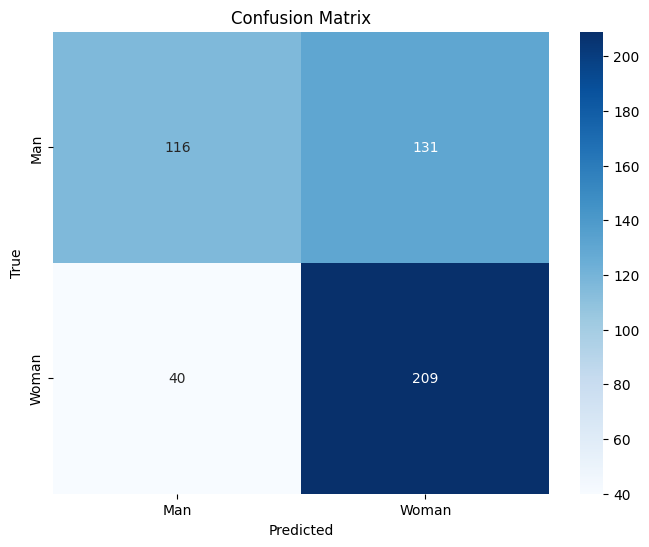

In [27]:
# Directory containing the test images
test_data_dir = "D:\Jupyter\Data Science Project\genderClassification\I don't know\Test"  # Replace with the path to your test data directory
img_width, img_height = 96, 96  # Adjust based on your image dimensions
batch_size = 64

# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Adjust based on your problem (binary or categorical)
    shuffle=False  # Set to False for evaluation
)

# Load your pre-trained VGG16 model
resnet_model = load_model('gender_classification_resnet_model.model')  # Replace with the path to your VGG16 model

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Iterate over subdirectories (Man and Woman)
for class_label in ['Man', 'Woman']:
    class_path = os.path.join(test_data_dir, class_label)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # List all image files in the subdirectory
        image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Select 302 images from each subdirectory
        image_files = image_files[:302]

        # Iterate over test images
        for img_path in image_files:
            # Load and preprocess the image
            img = load_img(img_path, target_size=(img_width, img_height))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict the gender using the VGG16 model
            prediction = resnet_model.predict(img_array,verbose=0)[0]
            predicted_label = 1 if prediction[0] > 0.5 else 0

            # Extract the true label from the subdirectory name
            true_label = 1 if class_label == 'Woman' else 0

            # Append true and predicted labels to the lists
            y_true.append(true_label)
            y_pred.append(predicted_label)

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Man", "Woman"],
            yticklabels=["Man", "Woman"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [28]:
cm

array([[116, 131],
       [ 40, 209]], dtype=int64)

In [29]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Man", "Woman"]))

Classification Report:
              precision    recall  f1-score   support

         Man       0.74      0.47      0.58       247
       Woman       0.61      0.84      0.71       249

    accuracy                           0.66       496
   macro avg       0.68      0.65      0.64       496
weighted avg       0.68      0.66      0.64       496



## ROC Curve

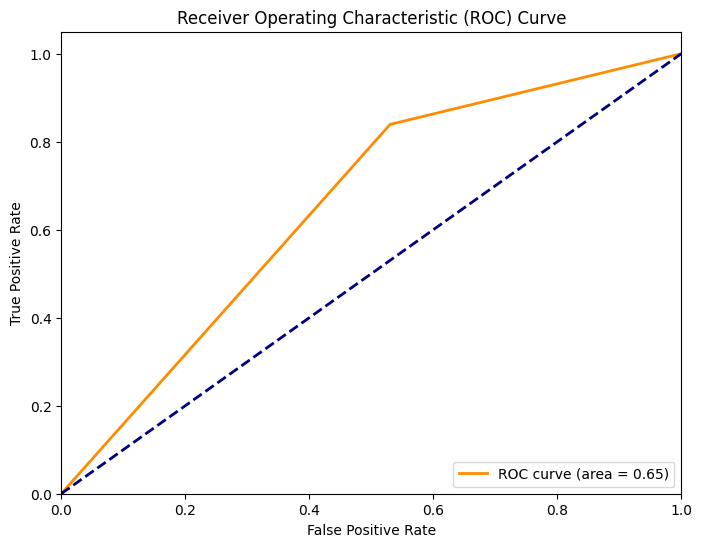

In [30]:
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Precision Recall Curve

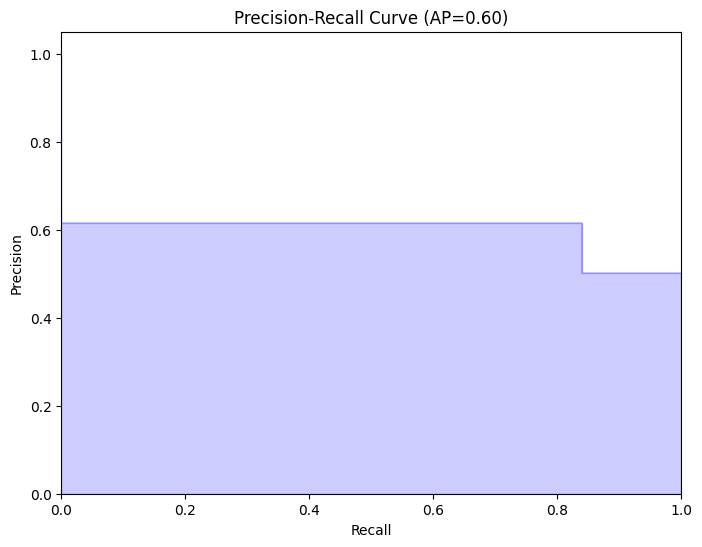

In [31]:
# Compute Precision-Recall curve and area for each class
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:.2f})'.format(average_precision))
plt.show()


## Implementing the model on realtime webcam

The model for the below code can be changed at will

In [45]:
# Load your trained model
model = load_model('gender_classification_model_v22.model')  # Replace with the path to your trained model

# Load the face cascade for detecting faces
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Open the webcam
webcam = cv2.VideoCapture(0)

while True:
    # Read a frame from the webcam
    _, frame = webcam.read()

    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # Iterate over detected faces
    for (x, y, w, h) in faces:
        # Crop the face region
        face_roi = frame[y:y+h, x:x+w]

        # Resize the face to the required input dimensions for your model
        face_roi = cv2.resize(face_roi, (96, 96))

        # Normalize pixel values and convert to array
        face_array = img_to_array(face_roi) / 255.0
        face_array = np.expand_dims(face_array, axis=0)

        # Use the trained model for gender classification
        prediction = model.predict(face_array)[0]
        gender = "Man" if prediction < 0.5 else "Woman"

        # Display the gender label on the frame
        cv2.putText(frame, f"Gender: {gender}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the frame
    cv2.imshow("Gender Classification", frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
webcam.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 48ms/step


In [44]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load your pre-trained model
model = load_model('gender_classification_vgg16_model.model')

# Input and output folders
input_folder = r'D:\Jupyter\Data Science Project\genderClassification\test_images'
output_folder = r'D:\Jupyter\Data Science Project\genderClassification\output_images'

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Iterate over images in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Load and preprocess the image
        img_path = os.path.join(input_folder, filename)
        img = load_img(img_path, target_size=(96, 96))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict the class using the model
        prediction = model.predict(img_array)[0]
        predicted_label = 'woman' if prediction[0] > 0.5 else 'man'

        # Read the original image
        original_image = cv2.imread(img_path)

        # Draw the predicted label on the image
        cv2.putText(original_image, predicted_label.capitalize(), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Save the result to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, original_image)

print("Classification and saving completed.")


1/1 [==============================] - 0s 117ms/step
Classification and saving completed.
